In [65]:
#!pip install kaggle
#!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset datasets

In [9]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2

from util import load_data, preprocess_data
from unet import unet

In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


In [11]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

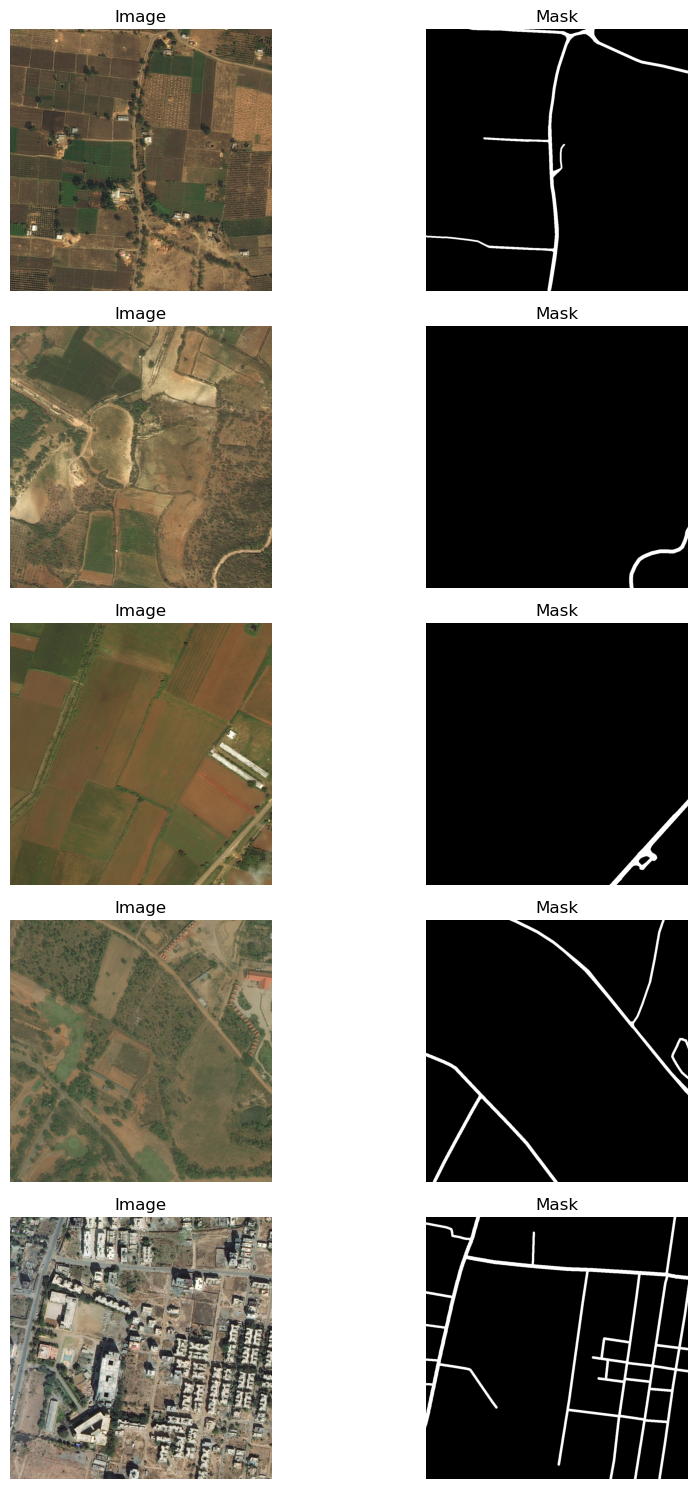

In [81]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 15))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')  # Save as PNG image

    # Show the plot
    plt.show()
    return

# load data
dir_path = 'datasets/'
image_filenames, mask_filenames = load_data(dir_path)

# display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices])


In [13]:
# preprocess data
with tf.device("/device:GPU:0"):
    # no augmentation due to limited computational resources
    # already have a large amount of data, roughly 12,000 images and masks
    images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE, augmented=False) 


In [82]:
# get shape
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (6226, 256, 256, 3)
Shape of mask data: (6226, 256, 256, 1)


The dataset includes 6226 images and 6226 mask. The images have 3 channels while the masks have only 1. 

In [14]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [14]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.h5', verbose=1, save_best_only=True)

<b>Given that we are predicting a binary mask, the output layer will be designed to accommodate this by having a size of 1.</b>

In [15]:
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
epochs = 20
with tf.device("/GPU:0"):
    history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])


Epoch 1/20


2023-06-17 19:32:42.798551: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


249/249 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.9043
Epoch 1: val_loss improved from inf to 0.18491, saving model to models/save_best.h5
249/249 [==============================] - 75s 271ms/step - loss: 0.4005 - accuracy: 0.9043 - val_loss: 0.1849 - val_accuracy: 0.9591
Epoch 2/20
249/249 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9600
Epoch 2: val_loss improved from 0.18491 to 0.12119, saving model to models/save_best.h5
249/249 [==============================] - 65s 261ms/step - loss: 0.1439 - accuracy: 0.9600 - val_loss: 0.1212 - val_accuracy: 0.9634
Epoch 3/20
249/249 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9648
Epoch 3: val_loss improved from 0.12119 to 0.09578, saving model to models/save_best.h5
249/249 [==============================] - 65s 261ms/step - loss: 0.1052 - accuracy: 0.9648 - val_loss: 0.0958 - val_accuracy: 0.9673
Epoch 4/20
249/249 [==============================] - ETA: 0s

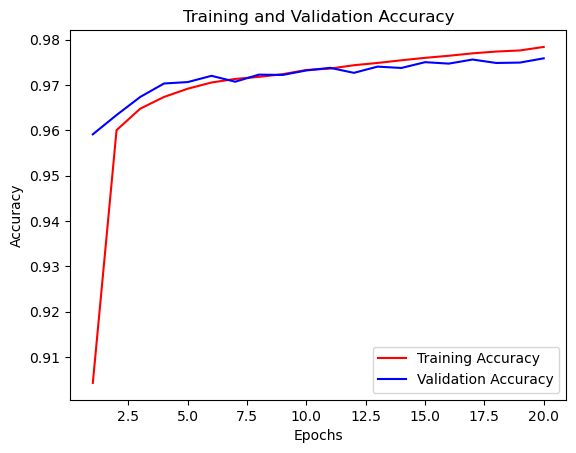

In [22]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
model.save('models/roads_extraction.h5')

NameError: name 'model' is not defined

In [29]:
eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

32/32 [==============================] - 4s 108ms/step - loss: 0.0697 - accuracy: 0.9755
Test accuracy: 0.98


In [7]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('models/roads_extraction.h5')

1/1 [==============================] - 0s 22ms/step


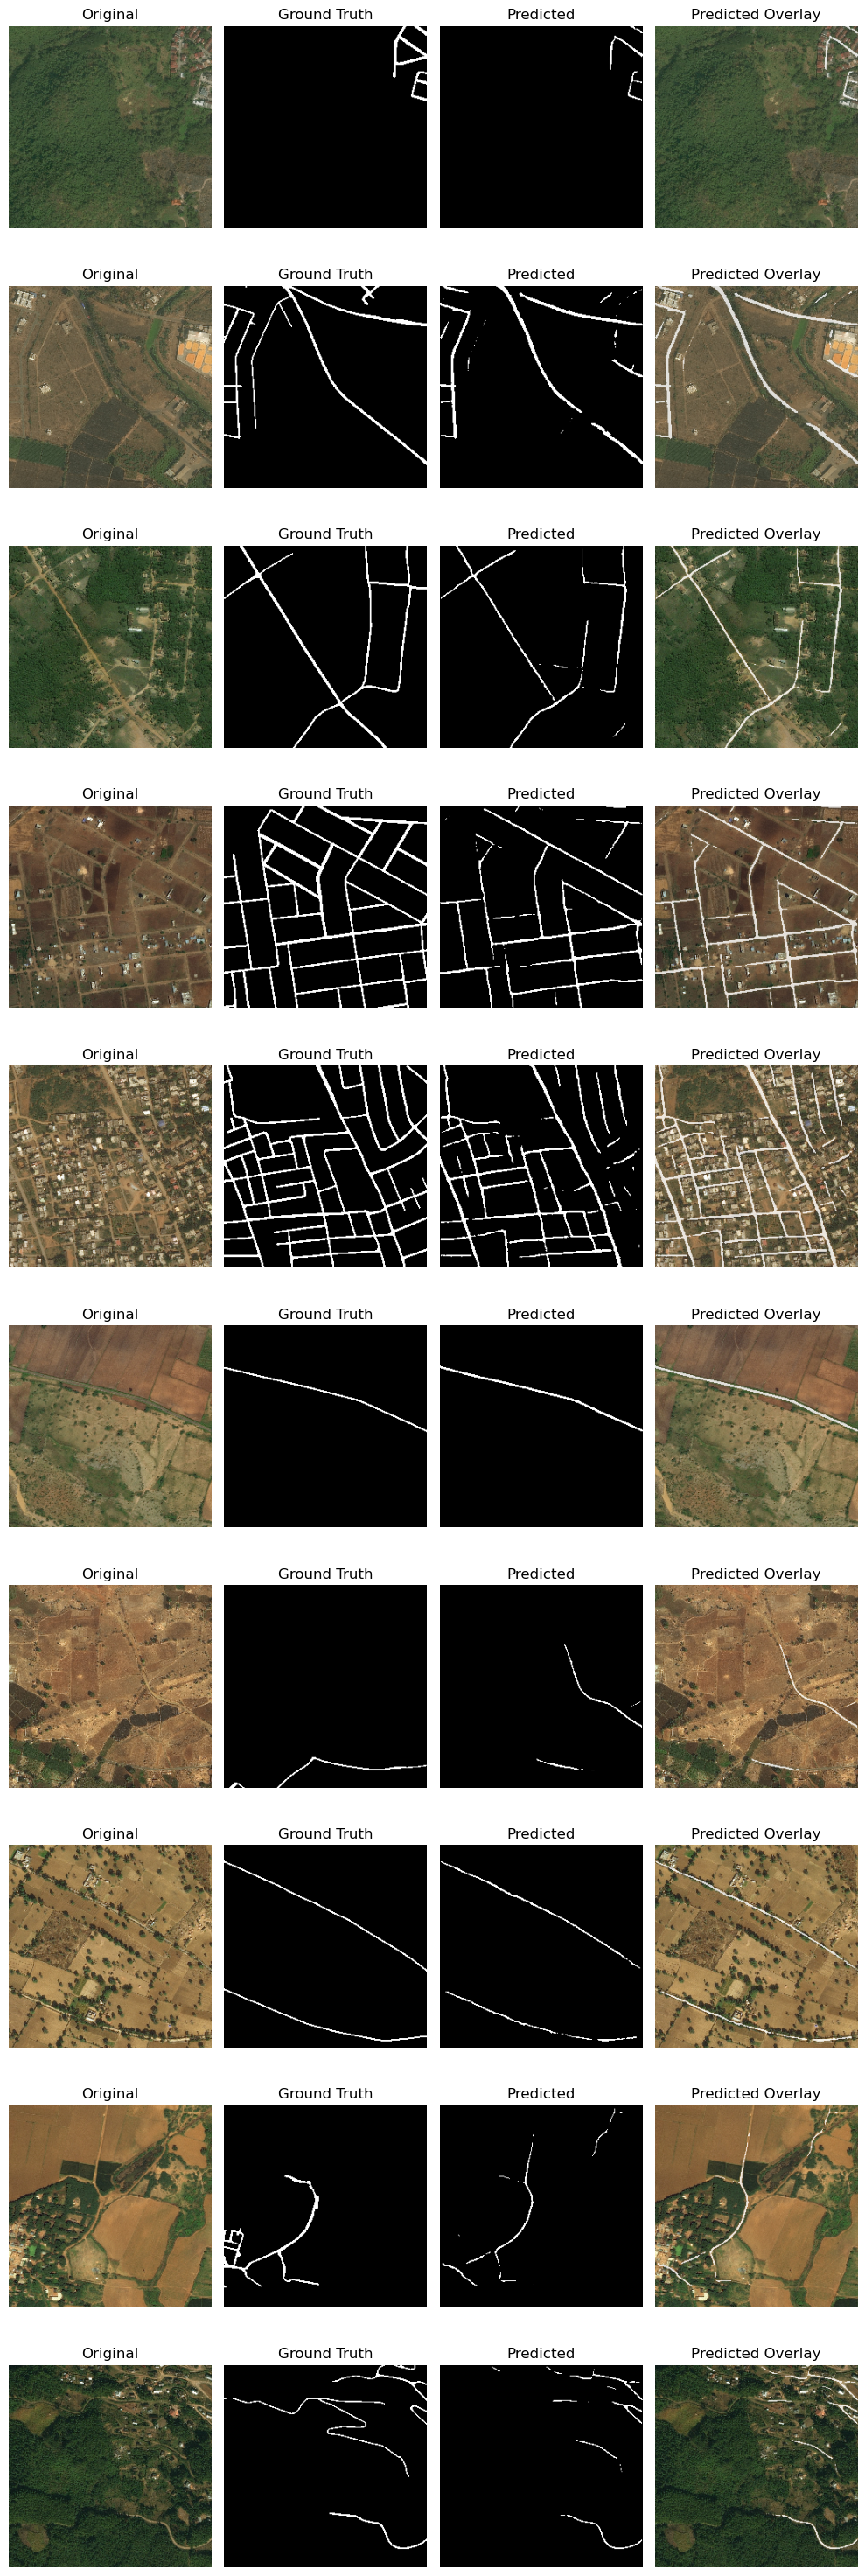

In [80]:
# display 10 random predictions
random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()
# save the output

